In [1]:
#!pip3 install lfpykit

In [1]:
%matplotlib inline

# if you want a specific arbor load location after a custom cmake build
# from https://stackoverflow.com/questions/67631/how-to-import-a-module-given-the-full-path
import sys
import importlib
ARBOR_LOCATION = '/specialhome/lennart/Repos/arbor-sim/arbor/build/python/arbor/__init__.py'
spec = importlib.util.spec_from_file_location('arbor', ARBOR_LOCATION)
module = importlib.util.module_from_spec(spec)
sys.modules[spec.name] = module
spec.loader.exec_module(module)

import random
from concurrent.futures import ThreadPoolExecutor, ProcessPoolExecutor
import numpy as np
import matplotlib.pyplot as plt

import lfpykit
import arbor

import iopublic
iopublic.ARBOR_BUILD_CATALOGUE = '/specialhome/lennart/Repos/arbor-sim/arbor/build/arbor-build-catalogue'

# Shared code

In [2]:
# from https://github.com/LFPy/LFPykit/blob/master/examples/Example_Arbor_swc.ipynb

class ArborCellGeometry(lfpykit.CellGeometry):
    def __init__(self, p, cables):
        x, y, z, r = [], [], [], []
        CV_ind = np.array([], dtype=int)  # tracks which CV owns segment
        for i, m in enumerate(cables):
            segs = p.segments([m])
            for j, seg in enumerate(segs):
                x.append([seg.prox.x, seg.dist.x])
                y.append([seg.prox.y, seg.dist.y])
                z.append([seg.prox.z, seg.dist.z])
                r.append([seg.prox.radius, seg.dist.radius])
                CV_ind = np.r_[CV_ind, i]
        x = np.array(x, dtype=float)
        y = np.array(y, dtype=float)
        z = np.array(z, dtype=float)
        d = 2*np.array(r, dtype=float)
        super().__init__(x=x, y=y, z=z, d=d)
        self._CV_ind = CV_ind


class ArborLineSourcePotential(lfpykit.LineSourcePotential):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self._get_transformation_matrix = super().get_transformation_matrix
    
    def get_transformation_matrix(self):
        M_tmp = self._get_transformation_matrix()
        n_CVs = np.unique(self.cell._CV_ind).size
        M = np.zeros((self.x.size, n_CVs))
        for i in range(n_CVs):
            inds = self.cell._CV_ind == i
            M[:, i] = M_tmp[:, inds] @ (self.cell.area[inds] / self.cell.area[inds].sum())
        return M

# Simulation

In [3]:
%%time
# 2 minutes
selected = '2021-12-08-shadow_averages_0.01_0.8_d1666304-c6fc-4346-a55d-a99b3aad55be'
neurons = iopublic.get_network_for_tuning(selected).neurons

tstart =  5000
tfinal = 6000
dt = 0.025
dt = 0.005
gpu_id = 1
num_sources = 100

def spiketrain(f_hz, a=0, b=tfinal):
    x = 0
    while True:
        interval = np.random.poisson(lam=1000/f_hz)
        x = x + interval
        if x > b:
            return
        if x >= a:
            yield x

spikes = []

for i in range(num_sources):
    tgt = random.choice(neurons)
    at = tuple([at for at in spiketrain(100, tstart-500, tfinal) if not (0 < at % 1000 < 100)])
    spikes.append((at, [tgt.x, tgt.y, tgt.z, 75, 0.000001, 'gaba']))
    at = tuple([at for at in spiketrain(10, tstart, tfinal) if (0 < at % 1000 < 100)])
    spikes.append((at, [tgt.x, tgt.y, tgt.z, 75, 0.001, 'ampa']))
        
print('done')
recipe = iopublic.build_recipe(
    selected,
    spikes=spikes
)
print('done')
context = arbor.context(threads=8, gpu_id=gpu_id)
domains = arbor.partition_load_balance(recipe, context)
sim = arbor.simulation(recipe, domains, context)
print('done')
tmem_current_handles = [sim.sample((gid, 2), arbor.regular_schedule(tstart, 5, tfinal), arbor.sampling_policy.exact) for gid in range(recipe.num_cells())]
stim_current_handles = [sim.sample((gid, 3), arbor.regular_schedule(tstart, 5, tfinal), arbor.sampling_policy.exact) for gid in range(recipe.num_cells())]
handles = [sim.sample((gid, 0), arbor.regular_schedule(1)) for gid in range(recipe.num_cells())]

done
done
done
CPU times: user 28.6 s, sys: 1.24 s, total: 29.8 s
Wall time: 26.9 s


In [5]:
%%time
# 12 minutes
sim.run(tfinal=tstart, dt=dt)

CPU times: user 14min 18s, sys: 17min 23s, total: 31min 42s
Wall time: 31min 20s


5000.0

In [6]:
I_meta = [sim.samples(handle)[0][1] for handle in tmem_current_handles]

In [7]:
%%time
# 2 minutes

N_SAMPLES = 64 # along 1 dimension. values > 10 = slow
soma = np.array([(a.x, a.y, a.z) for a in recipe.neurons]).T

sx = np.linspace(soma[0].min(), soma[0].max(), N_SAMPLES)
sy = np.linspace(soma[1].min(), soma[1].max(), N_SAMPLES)
z0 = soma[2].mean()
e = np.eye(3)

Xplane, Yplane = np.meshgrid(sx, sy)
X, Y, Z = (e[0]*Xplane.reshape(-1, 1) + e[1]*Yplane.reshape(-1, 1) + e[2]*z0).T
lsps = []
Ms = []
geometries = []
for gid in range(recipe.num_cells()):
    segtree = recipe.cell_morphology(gid)
    p = arbor.place_pwlin(arbor.morphology(segtree))
    cell_geometry = ArborCellGeometry(p, I_meta[gid])
    lsp = ArborLineSourcePotential(cell=cell_geometry, x=X, y=Y, z=Z)
    M = lsp.get_transformation_matrix()
    geometries.append(cell_geometry)
    lsps.append(lsp)
    Ms.append(M)
    if gid % 5 == 0:
        print(gid, end=' ', flush=True)

0 5 10 15 20 25 30 35 40 45 50 55 60 65 70 75 80 85 90 95 100 105 110 115 120 125 130 135 140 145 150 155 160 165 170 175 180 185 190 195 200 205 210 215 220 225 230 235 240 245 250 255 260 265 270 275 280 285 290 295 300 305 310 315 320 325 330 335 340 345 350 355 360 365 370 375 380 385 390 395 400 405 410 415 420 425 430 435 440 445 450 455 460 465 470 475 480 485 490 495 500 505 510 515 520 525 530 535 540 545 550 555 560 565 570 575 580 585 590 595 600 605 610 615 620 625 630 635 640 645 650 655 660 665 670 675 680 685 690 695 700 705 710 715 720 725 730 735 740 745 750 755 760 765 770 775 780 785 790 795 800 805 810 815 820 825 830 835 840 845 850 855 860 865 870 875 880 885 890 895 900 905 910 915 920 925 930 935 940 945 950 955 960 965 970 975 CPU times: user 22min 41s, sys: 1h 18min 6s, total: 1h 40min 47s
Wall time: 1min 45s


In [8]:
# 1 minutes per 1000 ms
# this loops prevents our GPU from running out of memory
# in steps of 1 second, we simulate the network
# each time, we clear the GPU memory, load back & reduce

concat_vsall = []
concat_Vext = []
concat_time = []
for tcurrent in range(tstart, tfinal, 1000):
    print(tcurrent, tcurrent+1000)
    # clear GPU memory
    sim.clear_samplers()
    # run simulation for 1 second
    #tmem_current_handles = [sim.sample((gid, 2), arbor.regular_schedule(tstart, 5, tfinal), arbor.sampling_policy.exact) for gid in range(recipe.num_cells())]
    #stim_current_handles = [sim.sample((gid, 2), arbor.regular_schedule(tstart, 5, tfinal), arbor.sampling_policy.exact) for gid in range(recipe.num_cells())]
    #handles = [sim.sample((gid, 0), arbor.regular_schedule(1)) for gid in range(recipe.num_cells())]
    sim.run(tfinal=tcurrent+1000, dt=dt)
    # get currents
    tmem_current_traces = [sim.samples(handle)[0] for handle in tmem_current_handles]
    stim_current_traces = [sim.samples(handle)[0] for handle in stim_current_handles]
    traces = [sim.samples(handle)[0][0].T for handle in handles]
    # get voltages
    vsall = np.array([vs for t, vs in traces])
    # get timestamps
    time = tmem_current_traces[0][0][:,0]
    # calculate total currents
    I_m  = [tmem[0][:,1:].T + stim[0][:,1:].T for tmem, stim in zip(tmem_current_traces, stim_current_traces)]
    # reduce to external potential
    V_ext = 0
    for gid in range(recipe.num_cells()):
        V_ext = V_ext + np.nan_to_num(Ms[gid] @ I_m[gid])
    V_ext = V_ext.reshape((N_SAMPLES, N_SAMPLES, -1))
    # save reduced values
    print(vsall.shape, np.isnan(vsall.ptp(1)).mean())
    concat_vsall.append(vsall)
    concat_Vext.append(V_ext)
    concat_time.append(time)
time = np.concatenate(concat_time)
vsall = np.hstack(concat_vsall)
Vext = np.concatenate(concat_Vext, axis=2)

5000 6000
(979, 1000) 0.0
6000 7000
(979, 1000) 0.0


Text(0.5, 1.0, 'LFP')

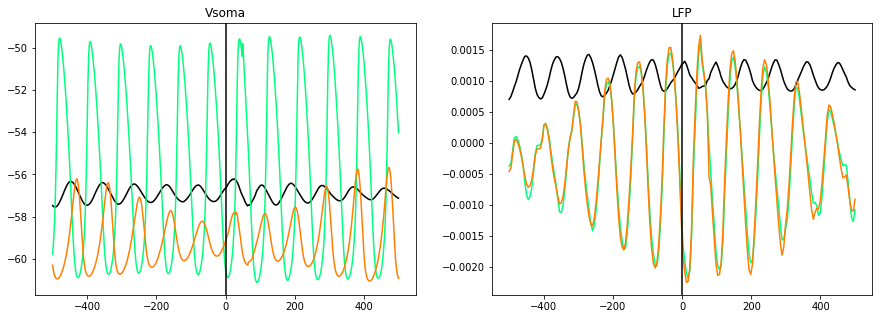

In [9]:
fig, ax = plt.subplots(ncols=2, figsize=(15, 5))
q = 0
n = 0
T = np.linspace(-500, 500, 1000)
for i in range(0, vsall.shape[1], 1000):
    v = np.nan_to_num(vsall[:,i-500:i+500])
    if v.shape[1] == 1000:
        q = q + v
        n = n + 1
        ax[0].plot(T, v.mean(0), color='black', alpha=0.1)
q = q / n
ax[0].plot(T, q.mean(0), color='black')
ax[0].plot(T, q[7], color='#00FF7F')
ax[0].plot(T, q[410], color='#FF7F00')
ax[0].axvline(0, color='black')
q = 0
n = 0
T = np.linspace(-500, 500, 200)
for i in range(0, Vext.shape[2], 200):
    v = np.nan_to_num(Vext[:,:,i-100:i+100])
    if v.shape[2] == 200:
        q = q + v
        n = n + 1
        plt.plot(T, v.mean(0).mean(0), color='black', alpha=0.1)
q = q / n
plt.plot(T, q.mean(0).mean(0), color='black')
ax[1].plot(T, q[2,3], color='#00FF7F')
ax[1].plot(T, q[5,3], color='#FF7F00')
ax[1].axvline(0, color='black')

ax[0].set_title('Vsoma')
ax[1].set_title('LFP')

(9.0, 1000.0)

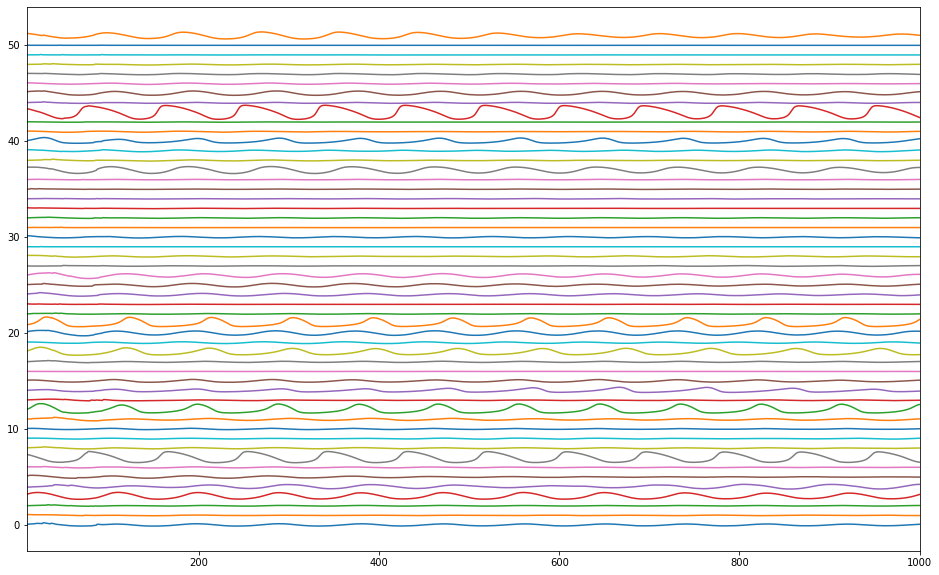

In [10]:
plt.figure(figsize=(16, 10))
for i in range(len(vsall)):
    v = vsall[i]
    v = (v - v.mean()) / 10
    plt.plot(v + i)
    if i > 50:
        break
        
plt.xlim([9,1000])